In [ ]:
from scipy.optimize import rosen
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize_scalar
import cma

# 2.1a

Gradient of of f_elli,cond
\begin{equation}
\nabla f_{elli,cond}(x) = \left[ \begin{array}{c}
\text{cond}^{\frac{0}{n-1}} x_1 \\
\text{cond}^{\frac{1}{n-1}} x_2 \\
\vdots \\
\text{cond}^{\frac{n-1}{n-1}} x_n
\end{array} \right]
\end{equation}

Hessian of f_elli,cond
\begin{equation}
H_{f_{elli,cond}(x)} = \left[ \begin{array}{cccc}
\text{cond}^{\frac{0}{n-1}} & 0 & \cdots & 0 \\
0 & \text{cond}^{\frac{1}{n-1}} & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & \text{cond}^{\frac{n-1}{n-1}}
\end{array} \right]
\end{equation}

Gradient of f_rot-elli, cond

\begin{equation}
\nabla f_{rot−elli,cond}(x) = R^T \nabla f_{elli,cond}(Rx)
\end{equation}

Hessian of f_rot−elli,cond(x)
\begin{equation}
H_{f_{rot−elli,cond}(x)} = R^T H_{f_{elli,cond}(Rx)} R
\end{equation}

In [ ]:
# We define it with cond**(i/n-1) as i starts from 0 instead of 1 in the code
def f_elli_cond(x, cond):
    n = len(x)
    return 0.5 * sum([(cond**((i)/(n - 1))) * (x[i]**2) for i in range(n)])


def grad_elli_cond(x, cond):
    n = len(x)
    return np.array([cond**(i/(n - 1)) * x[i] for i in range(n)])


def hess_elli_cond(x, cond):
    n = len(x)
    return np.diag([cond**(((i))/(n - 1)) for i in range(n)])


def f_rot_elli_cond(x, cond, R):
    y = np.dot(R, x)
    return f_elli_cond(y, cond)

def grad_rot_elli_cond(x, cond, R):
    y = np.dot(R, x)
    return np.dot(R.T, grad_elli_cond(y, cond))


def hess_rot_elli_cond(x, cond, R):
    return np.dot(np.dot(R.T, hess_elli_cond(x, cond)), R)


def condition_number(H):
    eigenvalues = np.linalg.eigvals(H)
    return abs(max(eigenvalues) / min(eigenvalues))


#eg:
n = 3
cond_value = 10
#45-degree rotation around the z-axis
theta = np.pi / 4
R = np.array([[np.cos(theta), -np.sin(theta), 0],
                            [np.sin(theta), np.cos(theta), 0],
                            [0, 0, 1]])

x = np.array([1.0, 3.0, 2.0])


f_elli_value = f_elli_cond(x, cond_value)
grad_elli = grad_elli_cond(x, cond_value)
hess_elli = hess_elli_cond(x, cond_value)

f_rot_elli_value = f_rot_elli_cond(x, cond_value, R)
grad_rot_elli = grad_rot_elli_cond(x, cond_value, R)
hess_rot_elli = hess_rot_elli_cond(x, cond_value, R)

cond_num_elli = condition_number(hess_elli)
cond_num_rot_elli = condition_number(hess_rot_elli)

print("Elliptical Function Value:", f_elli_value)
print("Gradient of Elliptical Function:", grad_elli)
print("Hessian of Elliptical Function:", hess_elli)
print("Condition Number of Elliptical Function Hessian:", cond_num_elli)

print("Rotated Elliptical Function Value:", f_rot_elli_value)
print("Gradient of Rotated Elliptical Function:", grad_rot_elli)
print("Hessian of Rotated Elliptical Function:", hess_rot_elli)
print("Condition Number of Rotated Elliptical Function Hessian:", cond_num_rot_elli)

Elliptical Function Value: 34.730249470757705
Gradient of Elliptical Function: [ 1.          9.48683298 20.        ]
Hessian of Elliptical Function: [[ 1.          0.          0.        ]
 [ 0.          3.16227766  0.        ]
 [ 0.          0.         10.        ]]
Condition Number of Elliptical Function Hessian: 10.0
Rotated Elliptical Function Value: 33.64911064067352
Gradient of Rotated Elliptical Function: [ 5.32455532  7.32455532 20.        ]
Hessian of Rotated Elliptical Function: [[ 2.08113883  1.08113883  0.        ]
 [ 1.08113883  2.08113883  0.        ]
 [ 0.          0.         10.        ]]
Condition Number of Rotated Elliptical Function Hessian: 10.000000000000002


We see that the condition number is preserved after the rotation (as the eigenvalues of the hessian are preserved)

# 2.1b


A function $f: \mathbb{R}^n \rightarrow \mathbb{R}$ is said to be $\mu$-strongly convex if for all $x, y \in \mathbb{R}^n$, the following inequality holds:
$$
f(y) \geq f(x) + \nabla f(x)^T (y - x) + \frac{\mu}{2} \| y - x \|^2
$$

And a function is $L$-smooth if its gradient is Lipschitz continuous with constant $L$, meaning that for all $x, y \in \mathbb{R}^n$, the following inequality holds:
$$
\| \nabla f(y) - \nabla f(x) \| \leq L \| y - x \|
$$

For the function $f_{elli,cond}(x)$, which is quadratic and its Hessian is a diagonal matrix $H$ with entries $\left( \text{cond} \right)^{\frac{i-1}{n-1}}$, we can determine its strong convexity and smoothness parameters directly from the Hessian:

- The smallest eigenvalue of the Hessian gives us the $\mu$ (strong convexity parameter).
- The largest eigenvalue of the Hessian gives us the $L$ (smoothness parameter).
- It is also useful to keep in mind that this allows us to define the condition number as $L$/$\mu$

For $f_{elli,cond}(x)$, the eigenvalues of the Hessian are the diagonal entries themselves. Therefore:

- $\mu$ is the smallest eigenvalue, which is $1$ (since $\left( \text{cond} \right)^{\frac{0}{n-1}} = 1$).
- $L$ is the largest eigenvalue, which is $\text{cond}$ (since $\left( \text{cond} \right)^{\frac{n-1}{n-1}} = \text{cond}$).

So for $f_{elli,cond}(x)$, the largest $\mu$ is indeed 1 (as the smallest eigenvalue is always 1) and the smallest possible $L$ is also 1 as 1 is the smallest possible max eigenvalue)

For $f_{rot−elli,cond}(x)$, the situation is a bit more complex due to the rotation. However, since a rotation is an orthogonal transformation, it preserves the eigenvalues of the Hessian. This means that the strong convexity and smoothness parameters remain the same even after the rotation:

- The function $f_{rot−elli,cond}(x)$ is still $1$-strongly convex.
- The function $f_{rot−elli,cond}(x)$ is still $\text{cond}$-smooth.

Thus, regardless of the rotation, the $\mu$ and $L$ for both $f_{elli,cond}(x)$ and $f_{rot−elli,cond}(x)$ depend on the $\text{cond}$ parameter, and they are the smallest and largest eigenvalues of their respective Hessian matrices. The largest $\mu$ would be $1$ (it cannot be greater since it's the smallest eigenvalue for any $\text{cond}$), and the smallest $L$ would be $1$ when $\text{cond} = 1$ (it cannot be smaller since $L$ grows with $\text{cond}$).


# 2.1c

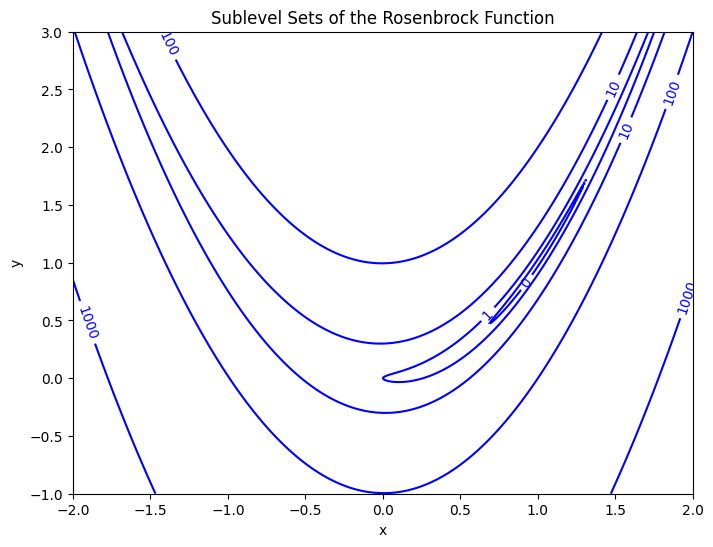

In [ ]:
x = np.linspace(-2, 2, 400)
y = np.linspace(-1, 3, 400)
X, Y = np.meshgrid(x, y)
Z = rosen((X, Y))


plt.figure(figsize=(8, 6))
contour_levels = [0.1, 1, 10, 100, 1000, 10000]
cp = plt.contour(X, Y, Z, levels=contour_levels, colors='blue')
plt.clabel(cp, inline=True, fontsize=10)
plt.title('Sublevel Sets of the Rosenbrock Function')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

We can see that the rosenbrock function's sublevel sets are not all convex. This violates the condition for quasi-convexity, which also eliminates any possibility for convexity.

# 2.2a

In [ ]:
def f_elli_cond(x, cond, n):
    return 0.5 * np.sum([(cond ** ((i) / (n - 1))) * (x[i] ** 2) for i in range(n)])

def coordinate_descent(cond, n, tol=1e-10, max_iter=1000):
    x = np.zeros(n)
    for k in range(max_iter):
        x_old = np.copy(x)
        for i in range(n):
            x[i] = 0
        if np.linalg.norm(x - x_old, ord=2) < tol:
            break
    return k + 1

conds = [10**i for i in range(7)]  # [1, 10, 10^2, ..., 10^6]
n = 10

for cond in conds:
    num_iter = coordinate_descent(cond, n)
    print(f"Condition number: {cond}, Number of iterations: {num_iter}")

Condition number: 1, Number of iterations: 1
Condition number: 10, Number of iterations: 1
Condition number: 100, Number of iterations: 1
Condition number: 1000, Number of iterations: 1
Condition number: 10000, Number of iterations: 1
Condition number: 100000, Number of iterations: 1
Condition number: 1000000, Number of iterations: 1


Given the function $f_{elli,cond}(x)$ defined as

$$
f_{elli,cond}(x) = \frac{1}{2} \sum_{i=1}^{n} \left(\text{cond}\right)^{\frac{i-1}{n-1}} x_i^2,
$$

the optimization problem for each coordinate $x_i$ while fixing the other coordinates is

$$
\min_{y \in \mathbb{R}} \frac{1}{2} \left(\text{cond}\right)^{\frac{i-1}{n-1}} y^2.
$$

This is a simple univariate quadratic optimization problem with the solution $y^* = 0$, since the derivative of the function with respect to $y$ is $\left(\text{cond}\right)^{\frac{i-1}{n-1}} y$, which is zero if and only if $y = 0$.

Because the function is separable (each $x_i$ can be optimized independently), the global minimum can be found by individually minimizing each coordinate. Therefore, coordinate descent will find the global minimum in a single iteration for each $x_i$, regardless of the value of $\text{cond}$, assuming exact arithmetic. The number of iterations required is thus one, given by

$$
k+1 = 1.
$$


#2.2b

In [ ]:
def f_elli_cond(x, cond, n):
    return 0.5 * np.sum([(cond ** ((i) / (n - 1))) * (x[i] ** 2) for i in range(n)])

def f_rot_elli_cond(x, cond, n, R):
    Rx = np.dot(R, x)
    return f_elli_cond(Rx, cond, n)

def coordinate_descent(func, initial_x, cond, n, R=None):
    x = np.array(initial_x)
    for k in range(100):
        x_old = np.copy(x)
        for i in range(n):

            def coord_func(xi):
                x_temp = np.copy(x)
                x_temp[i] = xi
                if R is not None:
                    return func(x_temp, cond, n, R)
                else:
                    return func(x_temp, cond, n)


            res = minimize_scalar(coord_func)
            x[i] = res.x


        if np.linalg.norm(x - x_old) < 1e-6:
            break
    return x, k + 1


n = 10
cond = 10
initial_x = np.random.rand(n)
R = cma.transformations.Rotation()(np.eye(n))  #random rotation matrix


solution, iter_non_rot = coordinate_descent(f_elli_cond, initial_x, cond, n)
print(f"Non-rotated function minimized in {iter_non_rot} iterations")

solution_rot, iter_rot = coordinate_descent(f_rot_elli_cond, initial_x, cond, n, R)
print(f"Rotated function minimized in {iter_rot} iterations")

Non-rotated function minimized in 2 iterations
Rotated function minimized in 21 iterations


# 2.2 c, d, e

Starting CD for non-rotated function with cond=1
Starting CD for rotated function with cond=1
Starting CD for non-rotated function with cond=10
Starting CD for rotated function with cond=10
Starting CD for non-rotated function with cond=100
Starting CD for rotated function with cond=100
Starting CD for non-rotated function with cond=1000
Starting CD for rotated function with cond=1000
Starting CD for non-rotated function with cond=10000
Starting CD for rotated function with cond=10000
Starting CD for non-rotated function with cond=100000
Starting CD for rotated function with cond=100000
Reached max iterations for cond=100000


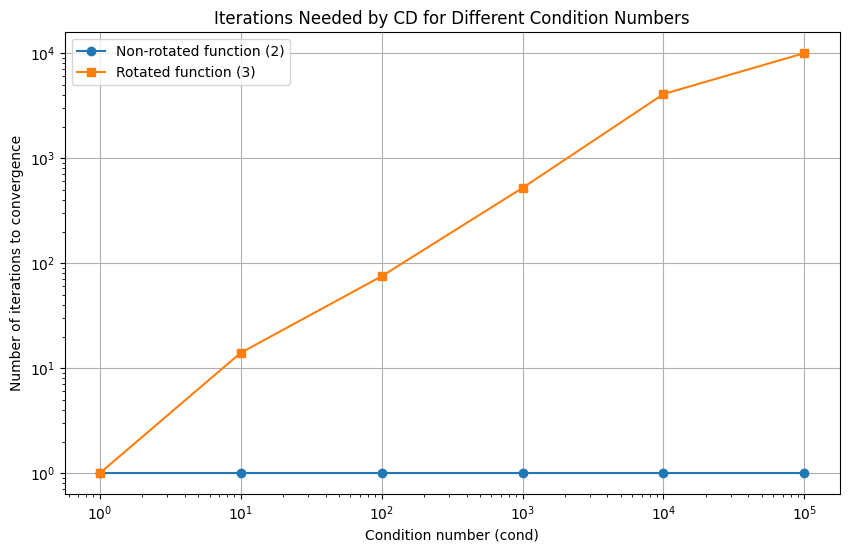

In [ ]:
def f_elli_cond(x, cond, n):
    return 0.5 * np.sum([(cond ** ((i) / (n - 1))) * (x[i] ** 2) for i in range(n)])

def f_rot_elli_cond(x, cond, n, R):
    Rx = np.dot(R, x)  # Apply rotation
    return f_elli_cond(Rx, cond, n)


def coordinate_descent(func, initial_x, cond, n, tol=1e-8, R=None, max_iter=10000):
    x = np.array(initial_x)
    for iteration_count in range(max_iter):
        x_old = np.copy(x)
        for i in range(n):
            def coord_func(xi):
                x_temp = np.copy(x)
                x_temp[i] = xi
                if R is not None:
                    return func(x_temp, cond, n, R)
                else:
                    return func(x_temp, cond, n)


            res = minimize_scalar(coord_func)
            x[i] = res.x


        func_val = func(x, cond, n, R) if R is not None else func(x, cond, n)
        if func_val < tol:
            break
    else:
        print(f"Reached max iterations for cond={cond}")
    return iteration_count + 1


n = 10
conds = [10**i for i in range(6)]
iterations_non_rotated = []
iterations_rotated = []
initial_x = np.random.rand(n)
R = cma.transformations.Rotation()(np.eye(n))

for cond in conds:
    print(f"Starting CD for non-rotated function with cond={cond}")
    iter_non_rot = coordinate_descent(f_elli_cond, initial_x, cond, n)
    iterations_non_rotated.append(iter_non_rot)

    print(f"Starting CD for rotated function with cond={cond}")
    iter_rot = coordinate_descent(f_rot_elli_cond, initial_x, cond, n, R=R)
    iterations_rotated.append(iter_rot)


plt.figure(figsize=(10, 6))
plt.plot(conds, iterations_non_rotated, 'o-', label='Non-rotated function (2)')
plt.plot(conds, iterations_rotated, 's-', label='Rotated function (3)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Condition number (cond)')
plt.ylabel('Number of iterations to convergence')
plt.title('Iterations Needed by CD for Different Condition Numbers')
plt.legend()
plt.grid(True)
plt.show()

The results are not surprising as they reflect the impact of rotation on the Coordinate Descent (CD) algorithm's performance. For $f_{elli,cond}(x)$, CD optimizes each coordinate independently, benefiting from the function's separability. However, for $f_{rot-elli,cond}(x)$, the rotation introduces dependencies between coordinates, increasing the complexity of the optimization landscape and the number of iterations needed.

This indicates that CD is not rotationally invariant. A rotationally invariant algorithm would show consistent performance regardless of linear transformations applied to the input space. The increased iterations for $f_{rot-elli,cond}(x)$ demonstrate that CD's performance is affected by such transformations, hence it is sensitive to rotations.


The non-rotational invariance of Coordinate Descent (CD) can be theoretically understood by examining the effect of rotations on the function's level sets. The CD algorithm is efficient when the level sets are axis-aligned, as in the case of $f_{elli,cond}(x)$, allowing direct progress toward the minimum along each coordinate direction. However, when a rotation $R$ is applied, the resulting function $f_{rot-elli,cond}(x) = f_{elli,cond}(Rx)$ has level sets that are no longer aligned with the coordinate axes. This misalignment causes each coordinate-wise step to potentially move in a non-optimal direction, thereby requiring more iterations for convergence. Hence, the CD algorithm's performance is sensitive to the orientation of the function's level sets and is not rotationally invariant.


# 2.3


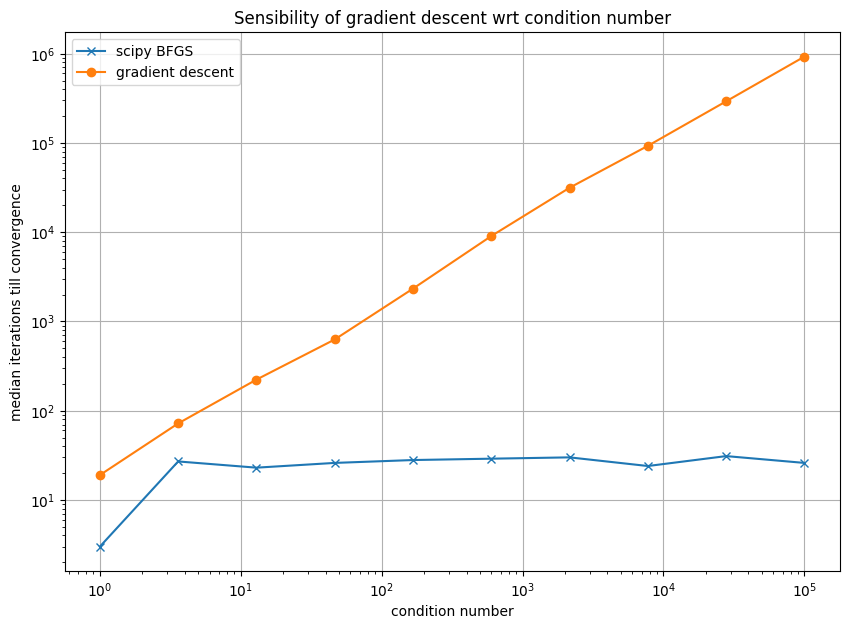

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

#We define (2) in a different way in order to have easy access to Q


def create_Q(cond, n=20):
    return np.diag([cond**(i/(n-1)) for i in range(n)])

def function_to_minimize(x, Q):
    return 0.5* (x.T @ Q @ x)


def gradient(x, Q):
    return Q @ x


def gradient_descent(Q, alpha, tol=1e-10):
    x = np.random.rand(Q.shape[0])
    num_iterations = 0
    while True:
        num_iterations += 1
        x_next = x - alpha * gradient(x, Q)
        if np.linalg.norm(function_to_minimize(x_next, Q) - function_to_minimize(x, Q)) < tol:
            break
        x = x_next
    return num_iterations


def bfgs(Q, tol=1e-10):
    x0 = np.random.rand(Q.shape[0])
    res = minimize(lambda x: function_to_minimize(x, Q), x0, method='BFGS', tol=tol, options={'disp': False})
    return res.nit


condition_numbers = np.logspace(0, 5, num=10)
iterations_bfgs = []
iterations_gd = []

for cond in condition_numbers:
    Q = create_Q(cond)
    iterations_bfgs.append(bfgs(Q))
    alpha = 1 / (2 * np.max(np.linalg.eigvals(Q)))
    iterations_gd.append(gradient_descent(Q, alpha))

plt.figure(figsize=(10, 7))
plt.loglog(condition_numbers, iterations_bfgs, 'x-', label='scipy BFGS')
plt.loglog(condition_numbers, iterations_gd, 'o-', label='gradient descent')
plt.xlabel('condition number')
plt.ylabel('median iterations till convergence')
plt.title('Sensibility of gradient descent wrt condition number')
plt.legend()
plt.grid(True)
plt.show()

(a)

Observations from the graph indicate that as the condition number increases, the number of iterations required for gradient descent increases significantly, following a roughly linear trend on the log-log scale. This implies an exponential increase in the number of iterations needed as the condition number increases. On the other hand, the BFGS method shows a much more modest increase in iterations (and it does not notably increase after a certain condition number) as the condition number grows, suggesting that BFGS is less sensitive to the condition number compared to gradient descent.

These observations can be related to the theoretical performance of these optimization algorithms. Gradient descent has a convergence rate that is heavily influenced by the condition number of the problem, particularly in the case of quadratic objective functions. As the condition number worsens, the optimization landscape becomes more elongated, leading to slower convergence of gradient descent.

In contrast, BFGS, being a quasi-Newton method, adapts its step sizes and directions by approximating the curvature of the function, which allows it to remain more robust to changes in the condition number. This results in a better performance of BFGS in terms of the number of iterations, especially for ill-conditioned problems.

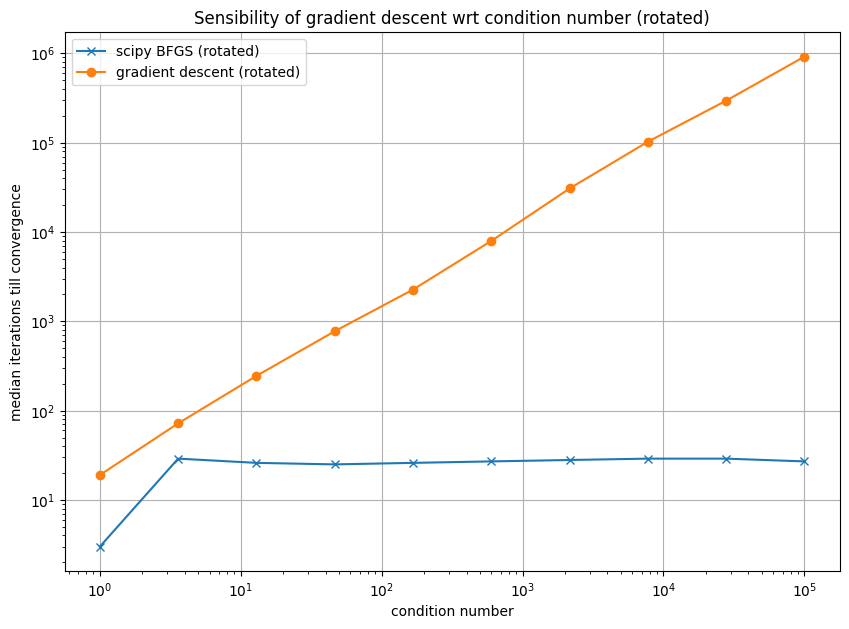

In [ ]:
from scipy.stats import ortho_group


def create_random_rotation_matrix(n):
    return ortho_group.rvs(dim=n)


def rotated_elliptical_function(x, Q, R):
    return 0.5* (x.T @ R.T @ Q @ R @ x)


def gradient_rotated(x, Q, R):
    return R.T @ Q @ R @ x


def gradient_descent_rotated(Q, R, alpha, tol=1e-10):
    x = np.random.rand(Q.shape[0])
    num_iterations = 0
    while True:
        num_iterations += 1
        x_next = x - alpha * gradient_rotated(x, Q, R)
        if np.linalg.norm(rotated_elliptical_function(x_next, Q, R) - rotated_elliptical_function(x, Q, R)) < tol:
            break
        x = x_next
    return num_iterations


def bfgs_rotated(Q, R, tol=1e-10):
    x0 = np.random.rand(Q.shape[0])
    res = minimize(lambda x: rotated_elliptical_function(x, Q, R), x0, method='BFGS', tol=tol, options={'disp': False})
    return res.nit


condition_numbers = np.logspace(0, 5, num=10)
iterations_bfgs_rotated = []
iterations_gd_rotated = []


for cond in condition_numbers:
    Q = create_Q(cond)
    R = create_random_rotation_matrix(Q.shape[0])
    iterations_bfgs_rotated.append(bfgs_rotated(Q, R))
    alpha = 1 / (2 * np.max(np.linalg.eigvals(Q)))
    iterations_gd_rotated.append(gradient_descent_rotated(Q, R, alpha))

# Plotting the results
plt.figure(figsize=(10, 7))
plt.loglog(condition_numbers, iterations_bfgs_rotated, 'x-', label='scipy BFGS (rotated)')
plt.loglog(condition_numbers, iterations_gd_rotated, 'o-', label='gradient descent (rotated)')
plt.xlabel('condition number')
plt.ylabel('median iterations till convergence')
plt.title('Sensibility of gradient descent wrt condition number (rotated)')
plt.legend()
plt.grid(True)
plt.show()


(b)

Similar to the optimization of the non-rotated elliptical function, the BFGS algorithm's performance remains relatively stable across different condition numbers.

The performance of gradient descent worsens significantly as the condition number increases, which is consistent with the behavior observed in the optimization of the non-rotated elliptical function. The increase in iterations needed for convergence is exponential with respect to the condition number.

In general, a rotation might introduce more complexity to the optimization landscape and make it more difficult for GD. However, in the case of our elliptical function, the rotation does not affect the eigenvalues and thus the condition number. This makes it so that we have a very similar empirical result for the GD in the non-rotated and rotated case. We have a very similar performance in both cases, even though it still consistently needs more iterations as the condition number increases.

# Exercise 2.4

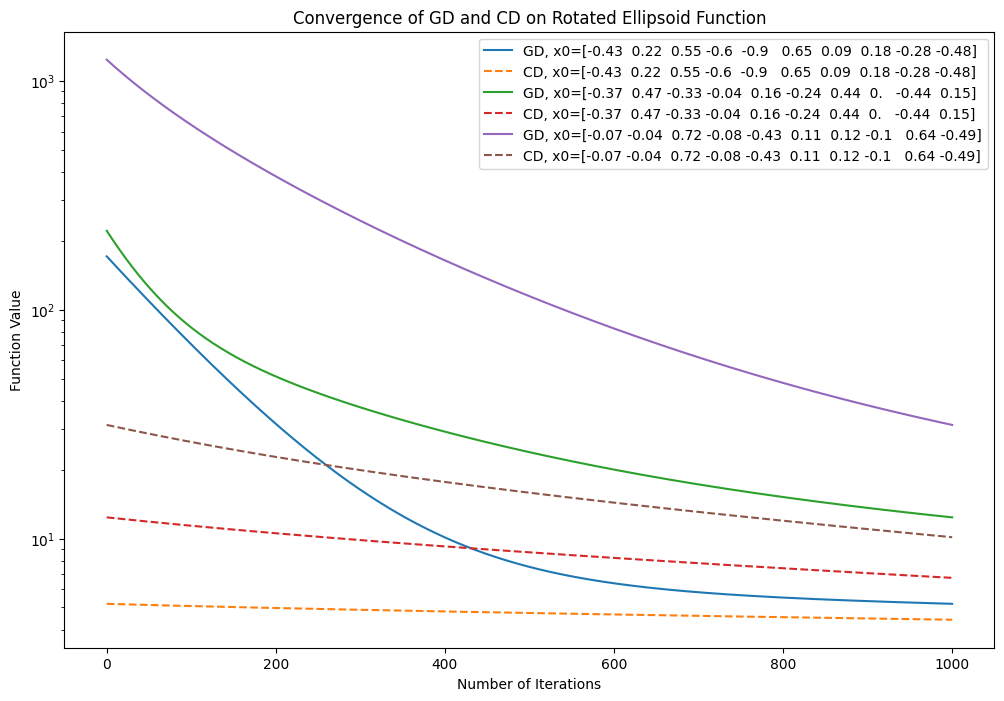

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable


def felli(x: np.ndarray, cond: float) -> float:
    n = len(x)
    return 0.5 * sum([(cond ** ((i) / (n - 1))) * x[i] ** 2 for i in range(n)])


def grad_felli(x: np.ndarray, cond: float) -> np.ndarray:
    n = len(x)
    return np.array([ (cond ** ((i) / (n - 1))) * x[i] for i in range(n)])

def simple_random_rotation_matrix(n: int) -> np.ndarray:
    random_matrix = np.random.randn(n, n)
    Q, _ = np.linalg.qr(random_matrix)
    return Q


def frot_elli(x: np.ndarray, cond: float, R: np.ndarray) -> float:
    return felli(np.dot(R, x), cond)


def grad_frot_elli(x: np.ndarray, cond: float, R: np.ndarray) -> np.ndarray:
    return np.dot(R.T, grad_felli(np.dot(R, x), cond))


def gradient_descent(f: Callable, grad_f: Callable, x0: np.ndarray, alpha: float, max_iter: int = 1000):
    x = x0
    convergence = [f(x)]
    for _ in range(max_iter):
        x -= alpha * grad_f(x)
        convergence.append(f(x))
    return x, convergence

def coordinate_descent(f: Callable, grad_f: Callable, x0: np.ndarray, alpha: float, max_iter: int = 1000):
    x = x0
    n = len(x0)
    convergence = [f(x)]
    for _ in range(max_iter):
        for i in range(n):
            grad = grad_f(x)
            x[i] -= alpha * grad[i]
        convergence.append(f(x))
    return x, convergence


n = 10
cond = 1e3

R = simple_random_rotation_matrix(n)


alpha_gd = 1e-5

x0_values = [np.random.randn(n) for _ in range(3)]


plt.figure(figsize=(12, 8))

for x0 in x0_values:
    _, conv_gd = gradient_descent(lambda x: frot_elli(x, cond, R), lambda x: grad_frot_elli(x, cond, R), x0, alpha_gd)
    _, conv_cd = coordinate_descent(lambda x: frot_elli(x, cond, R), lambda x: grad_frot_elli(x, cond, R), x0, alpha_gd)

    plt.plot(conv_gd, label=f'GD, x0={np.round(x0, 2)}')
    plt.plot(conv_cd, label=f'CD, x0={np.round(x0, 2)}', linestyle='--')

plt.xlabel('Number of Iterations')
plt.ylabel('Function Value')
plt.title('Convergence of GD and CD on Rotated Ellipsoid Function')
plt.legend()
plt.yscale('log')
plt.show()

    (a)
    
Step-Size Selection for Gradient Descent (GD):#

For the rotated ellipsoid function, the step-size was chosen as $\alpha = 1 \times 10^{-5}$. This value was selected considering the following factors:

Curvature of the Function: The rotated ellipsoid function has varying curvature, and a smaller step-size helps in navigating the steep gradients without overshooting.

Convergence Stability: A smaller step-size ensures more stable convergence, especially when dealing with the oscillations and rotations introduced by the rotation matrix \( R \).

Trial and Error: Through experimental runs, this step-size was found to balance convergence speed with the avoidance of divergence or oscillation.


Gradient Implementation:

The gradient of the rotated ellipsoid function is a key component in both GD and CD algorithms. It's computed as follows:

Given the ellipsoid function $ f_{elli}(x) = \frac{1}{2} \sum_{i=1}^{n} ( cond^{\frac{i-1}{n-1}} \cdot x_i^2 ) $, its gradient is:

 $\nabla f_{elli}(x) = \left[ \text{cond}^{\frac{0}{n-1}} \cdot x_1, \, \text{cond}^{\frac{1}{n-1}} \cdot x_2, \, \ldots, \, \text{cond}^{\frac{n-1}{n-1}} \cdot x_n \right] $

For the rotated ellipsoid function $ f_{rot\_elli}(\mathbf{x}) = f_{\text{elli}}(R\mathbf{x}) $, where  R is the rotation matrix, the gradient is given by the chain rule:

$ \nabla f_{rot\_elli}(\mathbf{x}) = R^T \nabla f_{\text{elli}}(R\mathbf{x}) $

This gradient is then used in the GD and CD algorithms to update the vector $ \mathbf{x} $ in each iteration.


    (b)

The convergence pattern for CD appears linear on the logarithmic scale, indicating exponential convergence in the original scale.

The convergence curve for GD, on the other hand, does not appear to be strictly linear on the logarithmic scale, especially in the initial phase. This indicates a convergence rate that is not exactly exponential. The curvature in the GD graph suggests that the convergence rate changes as the iterations progress. This could be due to the properties of the rotated ellipsoid function, where different regions of the function's landscape might have different curvatures, affecting the efficiency of gradient-based steps.

The non-linear (on a logarithmic scale) convergence for GD was initially surprising, but we should consider the nature of the rotated ellipsoid function. This function has varying curvature, and in regions where the curvature is higher, GD might take smaller steps, leading to slower convergence. As the algorithm approaches the minimum, where the curvature might be lower, the convergence might become faster.
Overall Comparison: The difference in convergence patterns between GD and CD can be attributed to their update mechanisms. GD updates all dimensions simultaneously, which can be less efficient in certain areas of the function landscape, whereas CD updates one coordinate at a time, potentially allowing for more consistent progress per iteration.


The impact of different initial vectors $x_0$ is evident in the graphs. Each initial vector leads to a distinct convergence path. This variation highlights the sensitivity of the optimization process to starting points. In optimization problems, particularly those involving complex landscapes like rotated functions, the initial vector can significantly influence the rate of convergence and the path taken to reach the minimum.

Both GD and CD show similar patterns of convergence, but there may be differences in their rates. GD updates all coordinates simultaneously, while CD does so one at a time. This distinction can lead to different convergence behaviors, especially in functions with varying curvature along different dimensions.

The results are in line with typical expectations for these algorithms on convex, smooth functions. However, the specific rate of convergence and the impact of the initial vector can vary depending on the function's characteristics and the chosen step size. The rotated ellipsoid function, with its varying curvature, provides a good test case to observe these effects.